# Final Project Reinforcement Learning

#### JOURDAN Pierre-Eliot, KOCH Alexandre

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Problem :
Time is discrete. We consider a job dispatcher sharing the load between two servers. Here is a figure explaining how the system under study works : 

![image](final_project_rl_img0.png " ")

A policy, in our problem, is a set of actions ($a_1$ or $a_2$ in the figure) for every state possible.
We define the parameters of our system below :

In [3]:
# Parameters :
Qmax = 20  # max number of jobs in each queue
mu1 = 0.2
mu2 = 0.4
lamb = 0.3
gamma = 0.99 # discount factor
delta = 0.001 # covergence threshold


First of all, we need to define our cost and reward vectors. As said in the subject, the cost in every time-slot is $Q_1 + Q_2$.
Our vectors will describe a value for every state ($Q_1, Q_2$) possible. Thus, we need to order the states in our vectors. We will have the following order :

| | | | | | | | |
|:--- |:----:|:---:|:----:|:---:|:---:|:-----:| -----:|
| States :|(0,0)|(0,1) | ... |(0,20)|(1,0)| ... |(20,20)

With this notation, we have the following cost vector :

![image](final_project_rl_img1.png "Cost vector")

We chose to define the reward in every time-slot as : $Rew = 2 \times Q_{\max} - (Q_1 + Q_2) = 2 \times Q_{\max} - Cost$

In [4]:
# Let's build the cost and reward vectors

x = [i for i in range(Qmax+1)]

def mat_cost(x,Q_i):
    X = np.zeros((Q_i+1)**2)
    for i in range(Q_i+1):
        for j in range(Q_i+1):
            X[j + (Q_i+1)*i] = x[j]+i
    return X

Cost = mat_cost(x,Qmax)

# Reward :
Rew = 2*Qmax*np.ones((Qmax+1)**2) - Cost

# print(np.shape(C))
#print('Cost vector =', Cost)
# print(np.shape(Rew))
#print('Reward vector =', Rew)

After that, the next step is to build the associated transition matrix $P^{\pi}$ as a function of the chosen policy $\pi$. We have $\pi = (p_1,p_2)$ with $p_1+p_2=1$.

With the choice of the order of the states made before, here is the shape of the transition matrix :

![image](final_project_rl_img2.png "Transition matrix P")

The transition matrix is a ($21 \times 21,21 \times 21$) bloc-tridiagonal matrix. Each bloc has a dimension of (21,21) ad can be defined as below :

![image](final_project_rl_img3.png " ")

![image](final_project_rl_img4.png " ")

![image](final_project_rl_img5.png " ")
![image](final_project_rl_img6.png " ")
![image](final_project_rl_img7.png " ")

New rule : The important point to take into account when building the transition matrix, is the fact that if $Q_1 = 20$ the new job will imperatively go to $Q_2$ (with probability $\lambda$) and vice versa.

The functions below will be used to build the transition matrix $P^{\pi}$ depending on the policy $\pi$ under study

In [9]:
# let's build the transition matrix P (bloc tridiagonal)

def mat_L(mu_i,Q_i):
    return np.eye(Q_i+1)*mu_i

def mat_R(lambda_i,Q_i,prob_i):
    R_mat = np.eye(Q_i+1)*lambda_i*prob_i
    R_mat[Q_i,Q_i] = lambda_i  # the new job will imperatively go to queue 1
    return R_mat

def mat_theta0(mu_j,lambda_i,Q_i,prob_i,prob_j):
    T = np.eye(Q_i+1)
    T[0,0] = T[0,0] - lambda_i*(prob_i + prob_j)
    T[Q_i,Q_i] = T[Q_i,Q_i] -  (mu_j + lambda_i)
    for i in range(Q_i):
        T[i,i+1] = lambda_i*prob_j
        T[i+1,i] = mu_j
        if i > 0 and i < Q_i:
            T[i,i] = T[i,i] - (lambda_i*(prob_i + prob_j) + mu_j)
    return T

def mat_theta(mu_i,mu_j,lambda_i,Q_i,prob_i,prob_j):
    T = mat_theta0(mu_j,lambda_i,Q_i,prob_i,prob_j)
    T = T - np.eye(Q_i+1)*mu_i
    return T

def mat_thetaK(mu_i,mu_j,lambda_i,Q_i,prob_i,prob_j):
    T = np.eye(Q_i+1)
    T[0,0] = T[0,0] - mu_i -lambda_i
    T[Q_i,Q_i] = T[Q_i,Q_i] - (mu_i + mu_j)
    for i in range(Q_i):
        T[i+1,i] = mu_j
        T[i,i+1] = lambda_i # the new job will imperatively go to queue 2
        if i > 0 and i < Q_i:
            T[i,i] = T[i,i] - (mu_i + mu_j) -lambda_i
    return T


def mat_P(L,R,T0,T,TK,Q_i):
    P_mat = np.block([T0, R, np.zeros((Q_i+1,(Q_i-1)*(Q_i+1)))])
    for i in range(1,Q_i):
        P_mat = np.block([[P_mat],[np.zeros((Q_i+1,(i-1)*(Q_i+1))), L, T, R, np.zeros((Q_i+1,(Q_i-i-1)*(Q_i+1)))]])
    P_mat = np.block([[P_mat],[np.zeros((Q_i+1,(Q_i-1)*(Q_i+1))), L, TK]])
    return P_mat



## 1. MDP

### 1.1 Policy Evaluation

Assume the random policy that dispatches every job with probability 0.5 to either queue 1 and 2.

- Let's first write the Bellman equation that characterizes the value function for this policy :

$V(s) = r(s) + \gamma \sum _{s'} p_{rand}(s,s') V(s')$, 

with : 
- $s$ the current state ($Q_1,Q_2$)
- $p_{rand}(s,s')$ the transition probability between the states $s$ and $s'$ for the random policy
- $V(s)$ the value function in state $s$
- $r(s)$ the reward in state $s$

The Bellman equation can also be written matricially :

$V = Rew + \gamma P_{rand} V$

with:
- $V$ the value function vector
- $Rew$ the reward vector (defined above)
- $P_{rand}$ the transition matrix associated with the random policy.

NB : We will keep the previous notations for the rest of the project (formulas, equations...).

We build the transition matrix $P_{rand}$ in the next cell :

In [19]:
rand_policy = [0.5, 0.5]  # random policy

L_rand = mat_L(mu1,Qmax)
R_rand = mat_R(lamb,Qmax,rand_policy[0])
T0_rand = mat_theta0(mu2,lamb,Qmax,rand_policy[0],rand_policy[1])
T_rand = mat_theta(mu1,mu2,lamb,Qmax,rand_policy[0],rand_policy[1])
TK_rand = mat_thetaK(mu1,mu2,lamb,Qmax,rand_policy[0],rand_policy[1])

P_rand = mat_P(L_rand,R_rand,T0_rand,T_rand,TK_rand,Qmax)
print(np.shape(P_rand))
#print('P = ')
#print(P_rand)
#print(np.sum(P_rand, axis=1))

(441, 441)


- After that, we can solve numerically the optimality value function by Iterative Policy Evaluation (see code below). We have the following equation :

$V_{k+1}(s) = r(s,a) + \gamma \sum_{s' \in S} p(s'|s,a) V_k(s')$

In [20]:
# Value Iteration Algorithm :

V0_rand = np.zeros((Qmax+1)**2)  # initial vector
diff_rand = delta + 1
while diff_rand > delta:
    V_rand = Rew + gamma*np.matmul(P_rand,V0_rand)
    diff_rand = max(abs(V0_rand-V_rand))
    V0_rand = V_rand

V_rand = np.reshape(V_rand,(Qmax+1,Qmax+1))
#print(np.shape(V_rand))
#print(V_rand)


- The two following functions will be used to plot the value function and the policy in 2D (as a function of ($Q_1, Q_2$)) :

In [21]:
def plot_value(V,policy_type):
    fig, ax = plt.subplots(figsize=(8,8))
    pos = ax.imshow(V, origin='lower')
    fig.colorbar(pos, ax=ax)
    ax.set_xlabel('Q2')
    ax.set_ylabel('Q1')
    ax.set_xticks(np.arange(0, Qmax + 1, 5))
    ax.set_yticks(np.arange(0, Qmax + 1, 5))
    ax.set_title('Heatmap of Value function for {policy_type} policy'.format(policy_type=policy_type))


def plot_policy(V,policy_type):
    fig, ax = plt.subplots(figsize=(8,8))
    for i in range(len(V)):
        for j in range(len(V)):
            text = ax.text(j, i, 2-int(V[i, j]),
                        ha="center", va="center", color="w")
    pos = ax.imshow(V, origin='lower')
    ax.set_xlabel('Q2')
    ax.set_ylabel('Q1')
    ax.set_xticks(np.arange(0, Qmax + 1, 5))
    ax.set_yticks(np.arange(0, Qmax + 1, 5))
    ax.set_title('Map of actions for {policy_type} policy'.format(policy_type=policy_type))


([<matplotlib.axis.XTick at 0x1fbca2d8d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

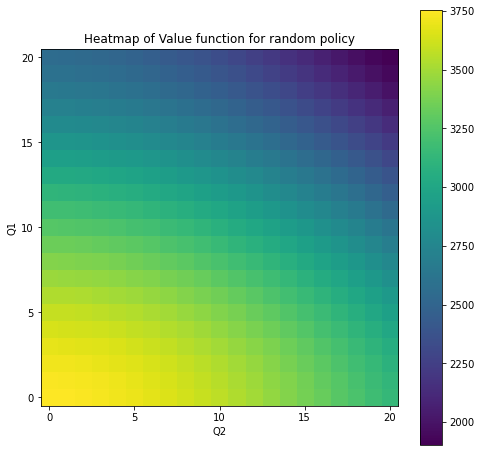

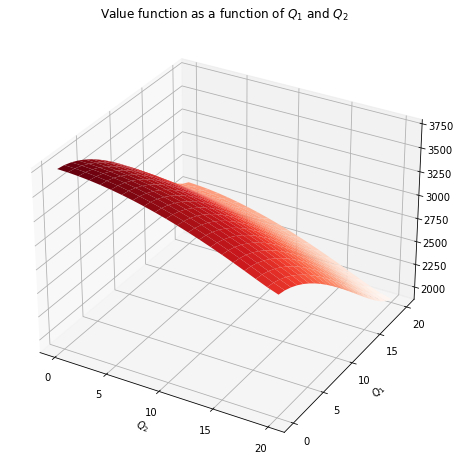

In [22]:
# 2D plot :
plot_value(V_rand,'random')

# 3D plot :
X1 = [i for i in range(Qmax+1)]
x1,x2 = np.meshgrid(X1, X1)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, V_rand, rstride=1, cstride=1,
                cmap='Reds', edgecolor='none')
ax.set_title('Value function as a function of $Q_1$ and $Q_2$')
ax.set_xlabel('$Q_2$')
ax.set_ylabel('$Q_1$')
plt.xticks(np.linspace(0,Qmax,5))
plt.yticks(np.linspace(0,Qmax,5))

# # policy plot :
# policy_rand = [random.randint(0, 1) for i in range((Qmax+1)**2)]
# policy_rand = np.reshape(policy_rand,(Qmax+1,Qmax+1))
# plot_policy(policy_rand,'random')


We notice we get a higher value function for small states (small $Q_1$ and $Q_2$), which makes sense since the reward is higher for these states.

- #### Bonus :

Let's show the policy could also be evaluated by calculating directly : $V = (I − \gamma P)^{−1}R$. We can plot in 2D the value function obtained with this equation and compare it with the one calculated with Value Iteration Algorithm.

The two plots (see result below) are similar which means we can evaluate the policy with these two methods : both solutions coincide.

(441,)


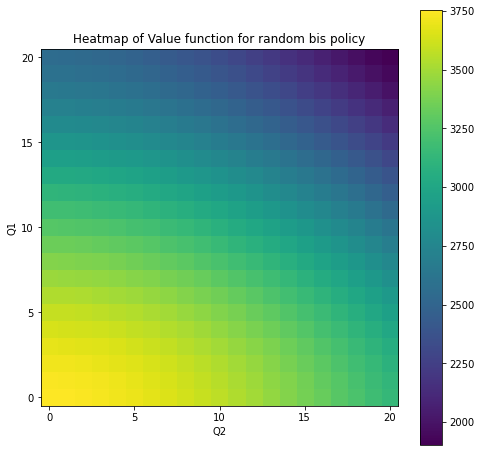

In [24]:
V_final = np.matmul(np.linalg.inv(np.eye((Qmax+1)**2) - gamma*P_rand),Rew)
print(np.shape(V_final))

V_final = np.reshape(V_final,(Qmax+1,Qmax+1))
plot_value(V_final,'random bis')


### 1.2 Optimal control

In this part we are asked to find the optimal policy to dispatch incoming jobs.

- The Bellman equation that characterizes the optimal policy can be written as followed :

$\pi^*(s) \in$ argmax $_{a \in A} [r(s,a) + \gamma \sum_{s' \in S} p(s'|s,a) V_*(s')]$

We also have : $V_*(s) =$ max $_{a \in A} [r(s,a) + \gamma \sum_{s' \in S} p(s'|s,a) V_*(s')]$

- Let's now solve numerically the optimality value function by Value Iteration Algorithm :

In [25]:
# Let's find the optimal policy :

policy1 = [1,0] # policy that only chooses queue 1 (for every state possible)
policy2 = [0,1] # policy that only chooses queue 2 (for every state possible)

# We build the associated transition matrices
L1 = mat_L(mu1,Qmax)
R1 = mat_R(lamb,Qmax,policy1[0])
T01 = mat_theta0(mu2,lamb,Qmax,policy1[0],policy1[1])
T1 = mat_theta(mu1,mu2,lamb,Qmax,policy1[0],policy1[1])
TK1 = mat_thetaK(mu1,mu2,lamb,Qmax,policy1[0],policy1[1])
P1 = mat_P(L1,R1,T01,T1,TK1,Qmax)

L2 = mat_L(mu1,Qmax)
R2 = mat_R(lamb,Qmax,policy2[0])
T02 = mat_theta0(mu2,lamb,Qmax,policy2[0],policy2[1])
T2 = mat_theta(mu1,mu2,lamb,Qmax,policy2[0],policy2[1])
TK2 = mat_thetaK(mu1,mu2,lamb,Qmax,policy2[0],policy2[1])
P2 = mat_P(L2,R2,T02,T2,TK2,Qmax)


With the 2 transition matrices we can compute the value function for every state and select the best action :

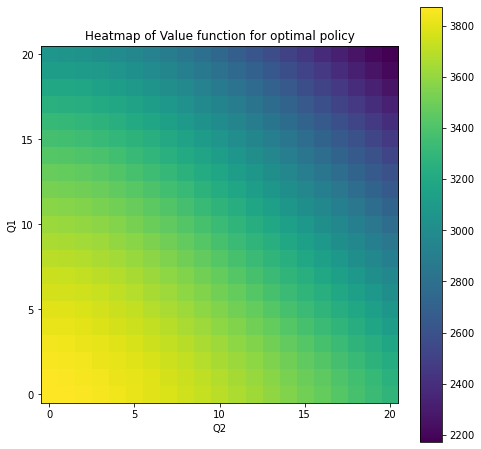

In [26]:
# Optimal policy algorithm :

V0_opt = np.zeros((Qmax+1)**2)
diff_opt = delta +1

while diff_opt > delta:
    V_opt = np.zeros((Qmax+1)**2)
    policy_opt = np.zeros(((Qmax+1)**2,2))

    for ind in range((Qmax+1)**2):
        V1 = Rew[ind] + gamma*np.matmul(P1[ind],V0_opt)
        V2 = Rew[ind] + gamma*np.matmul(P2[ind],V0_opt)
        #print(np.shape(V1))
        V_opt[ind] = max(V1,V2)
        if np.argmax([V1,V2]) == 0:
            policy_opt[ind,:] = policy1
        else:
            policy_opt[ind,:] = policy2

    diff_opt = max(abs(V0_opt-V_opt))
    V0_opt = V_opt

#print(V0_opt)
#print(policy_opt)
V_opt = np.reshape(V_opt,(Qmax+1,Qmax+1))
plot_value(V_opt, 'optimal')

- Let's represent on the plane the optimal action as a function of the state $(Q_1, Q_2)$ :

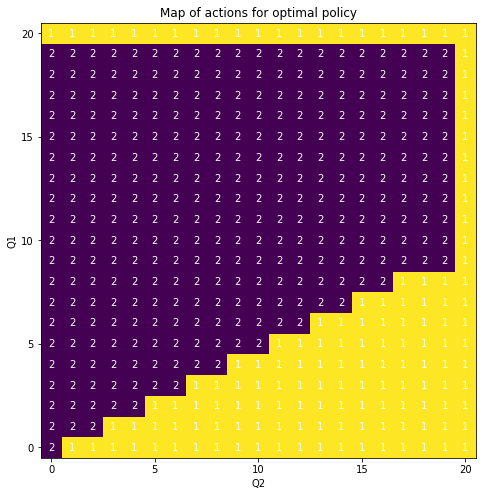

In [27]:
policy_opt1 = np.reshape(policy_opt[:,0],(Qmax+1,Qmax+1))
policy_opt2 = np.reshape(policy_opt[:,1],(Qmax+1,Qmax+1))

plot_policy(policy_opt1,'optimal')


([<matplotlib.axis.XTick at 0x1fbca473f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

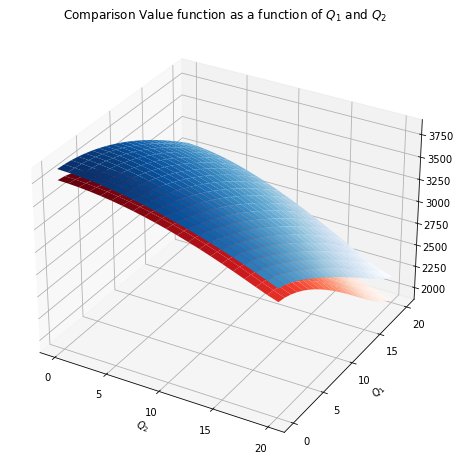

In [28]:
# 3D plot :

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, V_rand, rstride=1, cstride=1,
                cmap='Reds', edgecolor='none')
ax.plot_surface(x1, x2, V_opt, rstride=1, cstride=1,
                cmap='Blues', edgecolor='none')
ax.set_title('Comparison Value function as a function of $Q_1$ and $Q_2$')
ax.set_xlabel('$Q_2$')
ax.set_ylabel('$Q_1$')
plt.xticks(np.linspace(0,Qmax,5))
plt.yticks(np.linspace(0,Qmax,5))

The final value function of the optimal policy takes higher values than the random one :
- The heatmap colorbar for the optimal policy plots higher values ($[2200,3800]$ for optimal, $[2000,3750]$ for random).
- The yellow region on the optimal heatmap is bigger than on the random's (especially for $Q_1 \in \{8,10\}$).
- The last plot indeed shows that the value function obtained with the optimal policy is better.

Thus, the optimal policy performs better than the random policy.

The map of actions also illustrate that since instead of picking up an action randomly, the optimal policy will preferably select action 1 when $Q_2 \ge Q_1$ and vice-versa, which is the optimal behaviour.

- Let's now carry out a one-step improvement on the random policy (algorithm used in TP1):

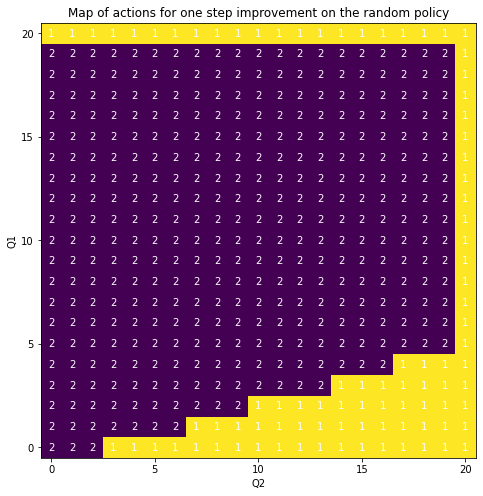

In [29]:
# One step improvement on the random policy :

V0_rand_bis = V0_rand
V_one_step = np.zeros((Qmax+1)**2)
policy_one_step = np.zeros(((Qmax+1)**2,2))

for ind in range((Qmax+1)**2):
    V1 = Rew[ind] + gamma*np.matmul(P1[ind],V0_rand_bis)
    V2 = Rew[ind] + gamma*np.matmul(P2[ind],V0_rand_bis)
    V_one_step[ind] = max(V1,V2)
    if np.argmax([V1,V2]) == 0:
        policy_one_step[ind,:] = policy1
    else:
        policy_one_step[ind,:] = policy2

plot_policy(np.reshape(policy_one_step[:,0],(Qmax+1,Qmax+1)),'one step improvement on the random')



The first policy $\pi_0$ was the random policy. We plot above the one step improvement $\pi_1$ on $\pi_0$. We observe that the map of actions is closer to the one we have with the optimal policy, which shows that $\pi_k$ is progressively converging towards the optimal policy.

+ cost as a function of nb steps

## 2. Tabular Model-Free control

### 2.1 Policy Evaluation

Assume the random policy that dispatches every job with probability 0.5 to either queue 1 and 2. For the learning parameter we will first use $\alpha_n = 1/n$.

For the rest of the project, we define the following function step() that gives the next state from the current one and the action taken.

In [5]:
def step(action,current_state):
    if action == 0:
        next_states = list(np.nonzero(P1[current_state]))[0]
        probas = P1[current_state,next_states]
    else:
        next_states = list(np.nonzero(P2[current_state]))[0]
        probas = P2[current_state,next_states]

    r = np.random.rand()
    ind=0
    summing = probas[0]
    while summing < r:
        ind += 1
        summing += probas[ind]
    return next_states[ind]


- Let's implement the TD(0) algorithm :

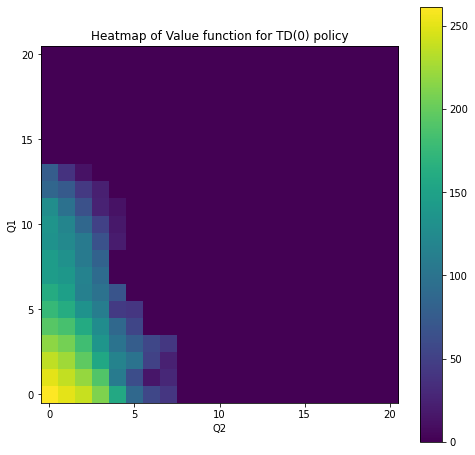

In [17]:
V0_td0 = np.zeros((Qmax+1)**2)
nb_episode = 10000
nb_step = 100
diff_td0 = delta + 1
num = np.ones((Qmax+1)**2)

for j in range(nb_step):
    V0_td0 = np.zeros((Qmax+1)**2)
    policy_td0 = np.zeros(((Qmax+1)**2,2))
    num = np.ones((Qmax+1)**2)
    current_state = 0

    for i in range(nb_episode):
        # select the expression of alpha :
        alpha = 1/num[current_state]
        #alpha = 1/(i+1)
        #alpha = 1/(i+1)**2
        #alpha = 0.9
        
        if np.random.rand() < rand_policy[0]:  # random policy
            action = 0
        else :
            action = 1
        next_state = step(action,current_state)
        V0_td0[current_state] = (1-alpha)*V0_td0[current_state] + alpha*(Rew[next_state] + V0_td0[next_state])
        current_state = next_state
        num[next_state] += 1

V_td0 = np.reshape(V0_td0,(Qmax+1,Qmax+1))
plot_value(V_td0,'TD(0)')


- Values for $\alpha$ :

We notice, first of all, that with $\alpha_n = 1/n$, the result is very bad. The algorithm only explores the states that verify : $Q_1 < 5$ and $Q_2 < 5$ (for the rest, value function = 0).

If we choose $\alpha_n = 1/n^2$, the result is even worse with only 2 states explored ((0,0) and (1,0)).

To improve this result, we can use the expression : $\alpha_n = 1/nb_{visit}$, $nb_{visit}$ being the number of visits in the current state.
The plot is better, there is more exploration but still too many states are never visited ($Q_1 > 15$ and $Q_2 > 10$).

Finally for $\alpha_n = cst$, the result is never better whatever constant is chosen.

([<matplotlib.axis.XTick at 0x2e0ffef17e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

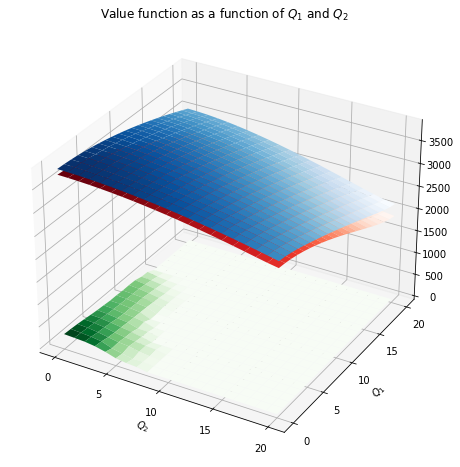

In [18]:
# 3D plot :

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, V_rand, rstride=1, cstride=1,
                cmap='Reds', edgecolor='none')
ax.plot_surface(x1, x2, V_opt, rstride=1, cstride=1,
                cmap='Blues', edgecolor='none')
ax.plot_surface(x1, x2, V_td0, rstride=1, cstride=1,
                cmap='Greens', edgecolor='none')
ax.set_title('Value function as a function of $Q_1$ and $Q_2$')
ax.set_xlabel('$Q_2$')
ax.set_ylabel('$Q_1$')
plt.xticks(np.linspace(0,Qmax,5))
plt.yticks(np.linspace(0,Qmax,5))



- On the previous 3D plot, we can compare the obtained value function with the results of Section 1. The obtained value function (here, for $\alpha_n = 1/nb_{visit}$) is way smaller than the ones computed in Section 1.

### 2.2 Optimal control

In this part, we want to find the optimal policy to dispatch incoming jobs, using the Q-learning algorithm.

- Let's first implement the Q-learning algorithm :

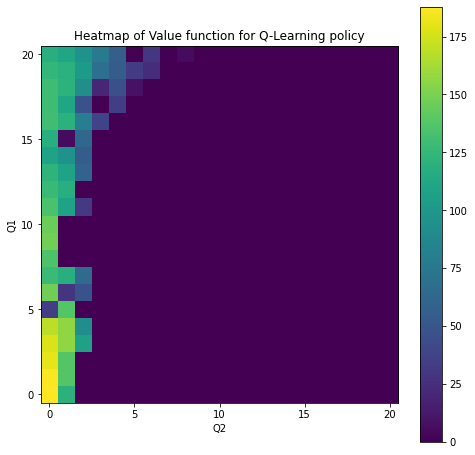

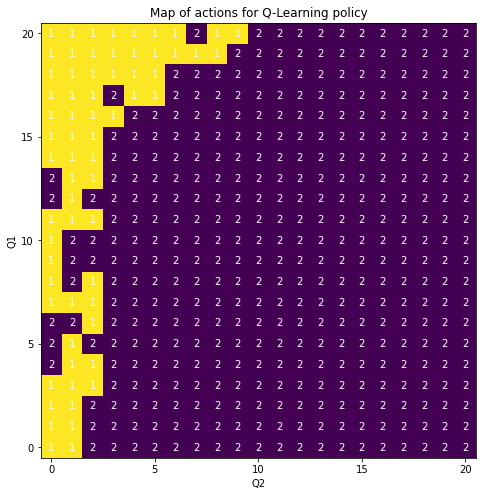

In [19]:
# Q-learning algorithm :

nb_episode = 10000
nb_step = 100

# Define the Q-table
V0_ql = np.zeros(((Qmax+1)**2, 2))

# Define the learning rate, discount factor, and exploration rate
alpha = 1
epsilon = 0.1
policy_ql = np.zeros(((Qmax+1)**2,2))

for j in range(nb_step):
    V0_ql = np.zeros(((Qmax+1)**2, 2))
    Vql_final = np.zeros((Qmax+1)**2)
    policy_ql = np.zeros(((Qmax+1)**2,2))
    current_state = 0
    num = np.ones((Qmax+1)**2)
    for i in range(nb_episode):
        # select the expression of alpha :
        alpha = 1/num[current_state]
        #alpha = 1/(i+1)
        #alpha = 1/(i+1)**2
        #alpha = 0.9

        # epsilon-greedy algorithm :
        if np.random.uniform(0, 1) <= epsilon:
            action = np.random.choice(2)
        else:
            action = np.argmax(V0_ql[current_state, :])
        next_state = step(action,current_state)
        V0_ql[current_state, action] = (1 - alpha) * V0_ql[current_state, action] + alpha * (Rew[next_state] + gamma * np.max(V0_ql[next_state, :]))
        current_state = next_state
        num[next_state] += 1
        Vql_final [current_state] = V0_ql[current_state, action]     
        if action == 0:
            policy_ql[current_state,:] = policy1
        else:
            policy_ql[current_state,:] = policy2
        

plot_value(np.reshape(Vql_final,(Qmax+1,Qmax+1)),'Q-Learning')
plot_policy(np.reshape(policy_ql[:,0],(Qmax+1,Qmax+1)),'Q-Learning')


- We plot on the plane above the optimal action. We notice there is more exploration than with the TD(0) algorithm. Nevertheless, the final value function is lower. Also, we notice that there is no exploration at all for $Q_2 > 10$ (see map of actions above).

NB : the Q-learning does not seem very suited for this problem, hence the solution proposed in section 3.

- Values of $\alpha$ : cf TD(0). Indeed, we notice the same effect of change on alpha over the value function. The best improvement possible is to use the expression : $\alpha_n = 1/nb_{visit}$.

## 3. Model-free control with Value Function/Policy approximation

As shown in the results of section 2, Q-learning is not very efficient in learning the optimal policy for this problem. The goal of this part is to build a model that can learn the optimal policy as found in Section 1 more efficiently than in Section 2 using a non-tabular approach.

- ### Rollout Algorithm :

Rollout algorithm is a model-based reinforcement learning (RL) method that evaluates the expected return of a fixed policy by "rolling out" the policy in a simulated environment. In other words, it uses simulations to estimate the value of the policy.

The algorithm starts from a given state and applies the policy's actions to generate a trajectory, which is a sequence of states, actions, and rewards. The expected return is estimated as the sum of discounted rewards along the trajectory : 

$\sum_{k=1}^{depth} \gamma^k*Rew[s_k]$ , (with $s_k$ the current state at step k and $depth$ the number of steps in the trajectory)

Therefore, the previous formula show that the more we explore the states along the trajectory, the less important the reward becomes (because of the discounted factor $\gamma$). 

The rollout algorithm can be used in both model-free and model-based RL. 

In model-free RL, the rollout algorithm is used as an approximation of the expected return of the policy, while in model-based RL, it can be used as a backup plan when the model is inaccurate or to improve the sample efficiency. It can also handle the absence of terminal state which makes it a good solution for our problem.


In [12]:
# We define a class State for this section
class State:
  def __init__(self,Q1,Q2):
    self.Q1 = int(Q1)
    self.Q2 = int(Q2)

  def get_possible_actions(self):
    return [1, 2]
  
  def __hash__(self):
    return hash((self.Q1, self.Q2))
    
  def __eq__(self, other):
    return (self.Q1, self.Q2) == (other.Q1, other.Q2)

  def get_reward(self):
    return self.Q1 + self.Q2



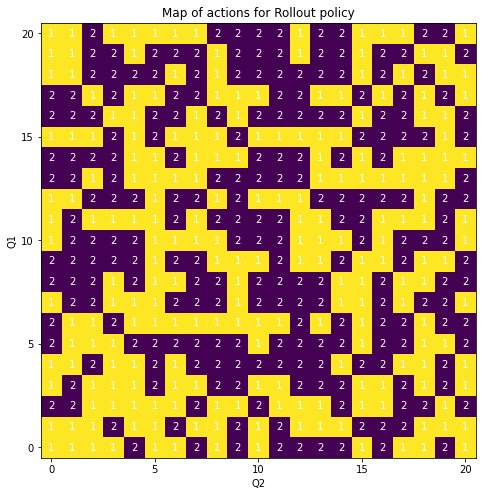

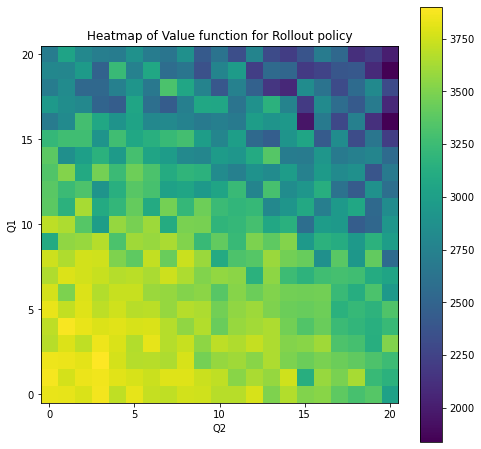

In [38]:
# Define the transition function
def transition_function(state, action):
    current_state = state.Q1*(Qmax+1) + state.Q2
    next_state_temp = step(action,current_state)
    reward = Rew[current_state]
    next_state = State(next_state_temp//(Qmax+1), next_state_temp%(Qmax+1))
    return next_state, reward

# Define the rollout function
def rollout(state, policy, depth):
    if depth == 0:
        return 0
    action = policy[state.Q1,state.Q2]
    next_state, reward = transition_function(state, action)
    return reward + gamma * rollout(next_state, policy, depth - 1)

# Define the policy iteration function
def policy_iteration(policy, value_function, max_depth):
    for epoch in range(50):
        policy_stable = True
        for i in range(21):
            for j in range(21):
                # select the starting state :
                state = State(i, j)
                old_action = policy[i,j]
                action_values = []
                for action in [0, 1]:
                    next_state, reward = transition_function(state, action)
                    action_values.append(reward + gamma * rollout(next_state, policy, max_depth))
                new_action = np.argmax(action_values)
                value_function[i,j] = max(action_values)
                policy[i,j] = new_action
                if old_action != new_action:
                    policy_stable = False
        if policy_stable:
            break
    return policy,value_function


def plot_policy_bis(policy):
    plt.imshow(policy, cmap='gray', extent=[0, 21, 0, 21])
    plt.xlabel("Queue 1")
    plt.ylabel("Queue 2")
    plt.show()


policy_rollout = np.zeros((21, 21))
value_function = np.zeros((21, 21))

policy_rollout, V_rollout = policy_iteration(policy_rollout, value_function, max_depth=2000)
#print(1-policy_rollout)
plot_policy(policy_rollout,'Rollout')
plot_value(V_rollout,'Rollout')

([<matplotlib.axis.XTick at 0x1fbcdfba3b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

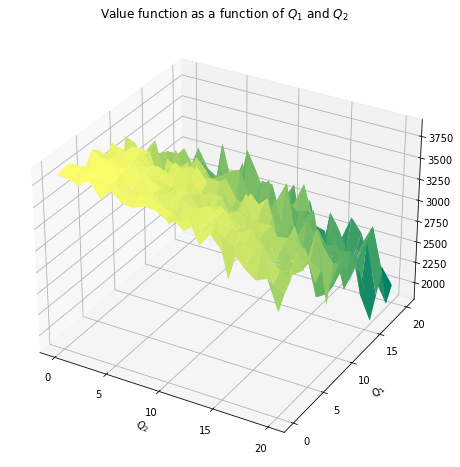

In [39]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.plot_surface(x1, x2, V_opt, rstride=1, cstride=1,
 #               cmap='Blues', edgecolor='none',label='Random')
ax.plot_surface(x1, x2, V_rollout, rstride=1, cstride=1,
                cmap='summer', edgecolor='none',label='TD(0)')
ax.set_title('Value function as a function of $Q_1$ and $Q_2$')
ax.set_xlabel('$Q_2$')
ax.set_ylabel('$Q_1$')
plt.xticks(np.linspace(0,Qmax,5))
plt.yticks(np.linspace(0,Qmax,5))

The results show that the Rollout algorithm is a way better solution than Q-learning. Indeed we can see there is a good exploration of all the states. Also when increasing the value of $\max_{depth}$ (the depth of the rollout), the 2D shape of the value function converges towards the one obtained with the optimal policy in Section 2. 

It is not relevant to compare them on the 3D plot since, the rollout algorithm is used as an approximation of the expected return of the policy.

A larger number of rollouts generally increases the accuracy of the algorithm and reduces the variance in the results. However, in some cases, the number of rollouts can become very large, leading to increased computation time and reduced efficiency. Hence, the number of rollouts should be chosen in a trade-off between accuracy and computational time.

After testing the code with different values for the parameters, it seems the best result is obtained for $N_{epochs} = 50$ and $\max_{depth} = 2000$.

The negative point is that the map of actions does not really seem to be optimal but random. Indeed, there is not any logic in the selection of actions that varies in every run of the algorithm. 

Therefore, the Rollout algorithm is not very performant in learning the optimal policy as found in Section 1, but it does it more efficiently than the tabular approach in Section 2. Its main strength would be the exploration of the states but the exploitation could be largely improved. 